# 使用UNET進行圖像分割





---


# kaggle導入數據集的方法

In [ ]:
# mkdir ~/.kaggle

In [ ]:
# cp kaggle.json ~/.kaggle/

In [ ]:
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle competitions download -c carvana-image-masking-challenge

In [ ]:
# ! unzip carvana-image-masking-challenge.zip



---



# import train_mask,train dataset

In [3]:
! chmod 600 train_masks.zip

In [4]:
! chmod 600 train.zip

In [ ]:
# !unzip trian_masks.zip

unzip:  cannot find or open trian_masks.zip, trian_masks.zip.zip or trian_masks.zip.ZIP.


In [ ]:
# !unzip train.zip

unzip:  cannot find or open train.zip, train.zip.zip or train.zip.ZIP.


In [22]:
pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import cv2
import numpy as np
import imageio
from scipy import ndimage
from glob import glob
import zipfile

In [8]:
path_to_zip_file = "train.zip"
directory_to_extract_to = "./output/"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
    
path_to_zip_file = "train_masks.zip"
directory_to_extract_to = "./output/"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [9]:
! pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-asrwwt2t
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-asrwwt2t
  Created wheel for tensorflow-examples: filename=tensorflow_examples-26080748173cc8236f805d2b65031b1e39fde4b1_-py3-none-any.whl size=299671 sha256=72a22c267b397f0fe4b6ee5f183b58f449b599b0b271eb18941a0fa734b85eb6
  Stored in directory: /tmp/pip-ephem-wheel-cache-gm_n7w0m/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/i

In [10]:
IMG_ROWS = 128
IMG_COLS = 128
SAMPLE = 1000

In [11]:
train_mask_paths  = sorted(glob("./output/train_masks/*.gif"))[:SAMPLE]


In [52]:
train_img_paths   = sorted(glob("./output/train/*.jpg"))[:SAMPLE]
test_img_paths = sorted(glob("./output/train/*.jpg"))[SAMPLE:2000]
# train_mask_paths  = sorted(glob("output/train_masks/*.gif"))[:SAMPLE]

# type(data_img_paths)

In [ ]:
train_img_paths   


In [54]:
train_imgs = np.array([cv2.resize(imageio.imread(path), (IMG_ROWS, IMG_COLS))
                        for path in train_img_paths])

train_imgs.shape

(1000, 128, 128, 3)

In [55]:
train_masks = np.array([cv2.resize(imageio.imread(path), (IMG_ROWS, IMG_COLS))
                        for path in train_mask_paths])
train_masks.shape

(1000, 128, 128)

In [56]:
test_imgs = np.array([cv2.resize(imageio.imread(path), (IMG_ROWS, IMG_COLS))
                        for path in test_img_paths])

test_imgs.shape

(1000, 128, 128, 3)

In [57]:
train_masks = train_masks.astype(np.float32)

In [58]:
train_masks[train_masks<=127] = 0.
train_masks[train_masks>127] = 1.
train_masks = np.reshape(train_masks, (*train_masks.shape, 1))

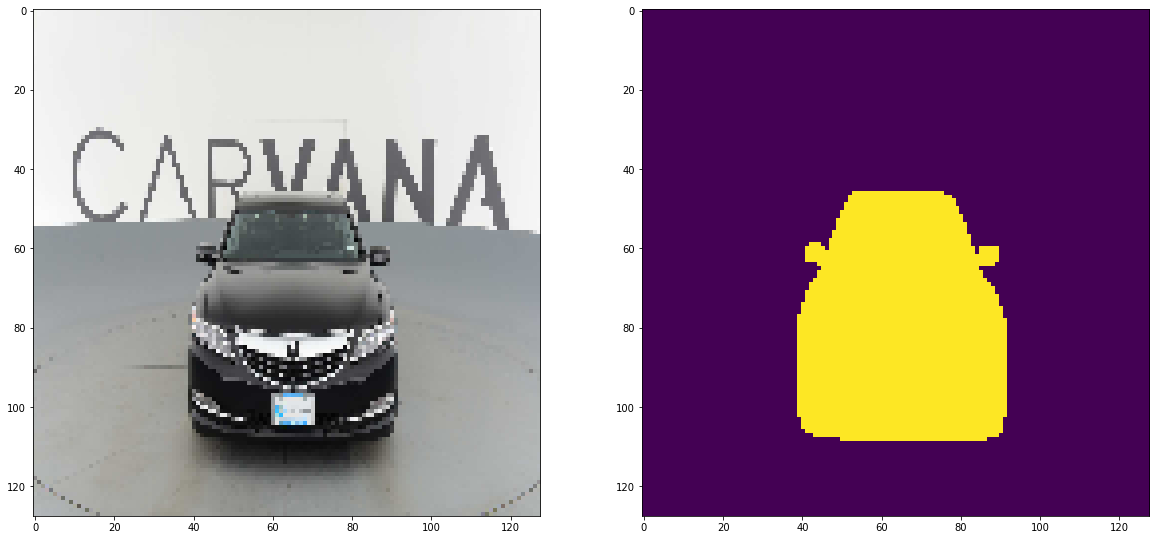

In [59]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(0, figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(train_imgs[0])
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(train_masks[0]))


# 定義模型

In [60]:
OUTPUT_CHANNELS = 3

In [72]:
import tensorflow as tf 
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# 使用这些层的激活设置
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 创建特征提取模型
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [73]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [74]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[IMG_COLS, IMG_ROWS, 3])
  x = inputs

  # 在模型中降频取样
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # 升频取样然后建立跳跃连接
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # 这是模型的最后一层
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [75]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

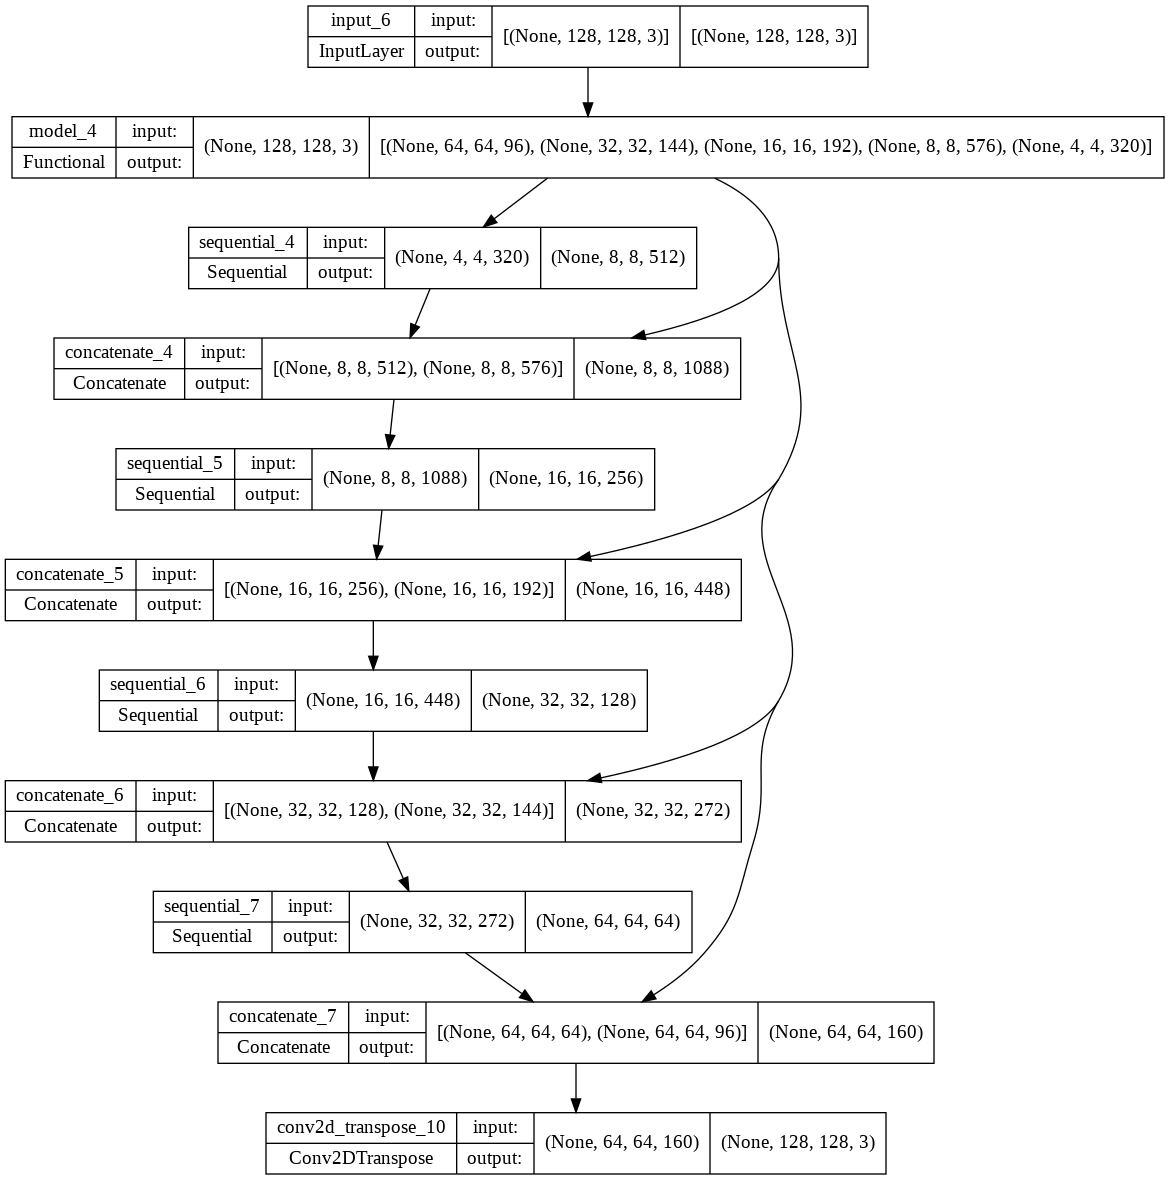

In [76]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [77]:
# def create_mask(pred_mask):
#   pred_mask = tf.math.argmax(pred_mask, axis=-1)
#   pred_mask = pred_mask[..., tf.newaxis]
#   return pred_mask[0]


In [105]:
# def show_predictions(dataset=None, num=1):
#   # 如果數據集有關鍵點的mask則顯示，否則就predict
#   # if dataset:
#   #   for image, mask in dataset.take(num):
#   #     pred_mask = model.predict(image)
#   #     display([image[0], mask[0], create_mask(pred_mask)])
#   # else:
#   # display([dataset[0],create_mask(model.predict(dataset[tf.newaxis, ...]))])
#   display([dataset[num],create_mask(model.predict(dataset[num]))])

In [81]:
EPOCHS = 10

model_history = model.fit(train_imgs,train_masks,
                          epochs=EPOCHS,
                          batch_size = 64,
                          validation_data=(train_imgs,train_masks))


Epoch 1/10
16/16 [==============================] - 20s 319ms/step - loss: 0.6203 - accuracy: 0.7505 - val_loss: 1.0525 - val_accuracy: 0.6669
Epoch 2/10
16/16 [==============================] - 3s 186ms/step - loss: 0.1681 - accuracy: 0.9419 - val_loss: 1.2775 - val_accuracy: 0.7185
Epoch 3/10
16/16 [==============================] - 3s 187ms/step - loss: 0.1003 - accuracy: 0.9666 - val_loss: 0.9858 - val_accuracy: 0.7762
Epoch 4/10
16/16 [==============================] - 3s 187ms/step - loss: 0.0749 - accuracy: 0.9740 - val_loss: 0.4803 - val_accuracy: 0.8684
Epoch 5/10
16/16 [==============================] - 3s 196ms/step - loss: 0.0647 - accuracy: 0.9768 - val_loss: 0.1526 - val_accuracy: 0.9479
Epoch 6/10
16/16 [==============================] - 3s 192ms/step - loss: 0.0566 - accuracy: 0.9793 - val_loss: 0.0815 - val_accuracy: 0.9697
Epoch 7/10
16/16 [==============================] - 3s 190ms/step - loss: 0.0514 - accuracy: 0.9810 - val_loss: 0.0557 - val_accuracy: 0.9794
Epoch

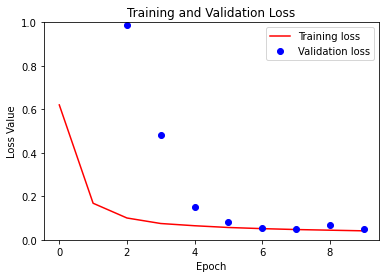

In [84]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [92]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_4 (Functional)           [(None, 64, 64, 96)  1841984     ['input_6[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

In [91]:
test_imgs[0].shape

(128, 128, 3)

In [95]:
# show_predictions(test_imgs,3)
test_imgs[0] = test_imgs[0][tf.newaxis, ...]


In [102]:
pred = model.predict(test_imgs[0][tf.newaxis, ...])
pred

array([[[[  2.1102443 ,  -0.43901592,  -4.410757  ],
         [  3.3177893 ,  -0.9746422 ,  -4.1402826 ],
         [  3.4623504 ,  -1.1785663 ,  -7.7614756 ],
         ...,
         [  3.9314613 ,  -1.369155  ,  -4.134365  ],
         [  3.8235066 ,  -0.83061117,  -7.5388255 ],
         [  3.8906994 ,  -1.041287  ,  -3.8283322 ]],

        [[  3.160224  ,  -0.79142   ,  -5.0834155 ],
         [  5.028476  ,  -1.1901526 ,  -5.1955185 ],
         [  6.0194464 ,  -2.1072116 , -11.45159   ],
         ...,
         [  4.6373577 ,  -1.660061  ,  -4.658918  ],
         [  5.7739515 ,  -1.8396926 ,  -9.976291  ],
         [  5.109963  ,  -0.32829887,  -5.524802  ]],

        [[  2.8154767 ,  -1.895918  ,  -7.5997243 ],
         [  4.0435553 ,  -2.3953097 ,  -6.995949  ],
         [  8.844458  ,   0.07572919, -10.758699  ],
         ...,
         [  4.077035  ,  -2.282699  ,  -6.210689  ],
         [  6.1941476 ,  -0.6219511 , -10.172272  ],
         [  3.9797506 ,  -1.7250217 ,  -6.441413  ]],